# 4. Counting Retained Reads with Chopper

In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data/")

In [3]:
# Define directories
raw_dir <- "~/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated"
filt_dir <- "~/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/chopper_filter"

# Get list of raw and filtered FASTQ files
raw_files <- list.files(raw_dir, pattern = "\\.fastq$", full.names = TRUE)
filt_files <- list.files(filt_dir, pattern = "_filtered\\.fastq$", full.names = TRUE)

print("Raw files:")
print(raw_files)

print("Filtered files:")
print(filt_files)

[1] "Raw files:"
  [1] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0001967K_T1.fastq" 
  [2] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0001967K_T3.fastq" 
  [3] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0001967K_T6.fastq" 
  [4] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0018303G_T0.fastq" 
  [5] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0088303G_T0.fastq" 
  [6] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0088303G_T1.fastq" 
  [7] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0088303G_T3.fastq" 
  [8] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0110059G_T0.fastq" 
  [9] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data/raw_data/concatenated/0110

In [4]:
# Function to count reads in a FASTQ file
count_reads <- function(file) {
  lines <- length(readLines(file))
  return(lines / 4)  # Each read has 4 lines
}

# Create an empty data frame to store results
results <- data.frame(ID_Sample = character(), raw_reads = integer(), filt_reads = integer())

# Process each raw file
for (raw_file in raw_files) {
  # Extract sample ID
  sample_id <- gsub("\\.fastq$", "", basename(raw_file))
  
  # Define the corresponding filtered file
  filt_file <- file.path(filt_dir, paste0(sample_id, "_filtered.fastq"))
  
  # Count reads
  raw_count <- count_reads(raw_file)
  filt_count <- if (file.exists(filt_file)) count_reads(filt_file) else NA
  
  # Append to results
  results <- rbind(results, data.frame(ID_Sample = sample_id, raw_reads = raw_count, filt_reads = filt_count))
}

# Print results
print(results)

       ID_Sample raw_reads filt_reads
1    0001967K_T1      1061        671
2    0001967K_T3     20860      10726
3    0001967K_T6     48290      27705
4    0018303G_T0     25719      14273
5    0088303G_T0      9051       5458
6    0088303G_T1     11707       5867
7    0088303G_T3      3587       2095
8    0110059G_T0      4792       2312
9    0110059G_T1       367        245
10  0110059G_T12       828        520
11   0110059G_T3      4188       2313
12   0110059G_T6      3272       1912
13   0120695B_T0     12912       8429
14   0130765A_T0      4773       2068
15   0130765A_T1      3901       1894
16  0130765A_T12       921        561
17   0130765A_T3      5904       3519
18   0130765A_T6      4538       2485
19   0207720E_T0     14784       7780
20   0207720E_T1      2168        969
21  0207720E_T12      3331       1803
22   0207720E_T3     13647       6661
23   0236549G_T0      2611       1395
24  0236549G_T12      4297       1946
25   0236549G_T3      6547       3559
26   0236549

In [5]:
# Save results as a table
write.table(results, file = "read_counts_chopper.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

In [6]:
## Check how many files have a lower number of reads (<1000)
out_df <- as.data.frame(results) # convert this matrix to a df

## Count the number of samples with reads.out < 1000
low_reads_count <- sum(out_df$raw_reads < 1000)

## Count the number of samples with reads.out >= 1100
high_reads_count <- sum(out_df$filt_reads >= 1000)

## Create a named vector for the pie chart
reads_distribution <- c("Low Reads (<1000)" = low_reads_count, "High Reads (>=1000)" = high_reads_count)

## Create labels with absolute counts
labels <- paste(names(reads_distribution), "\n", reads_distribution)

## Set the output file as PNG
png("reads_distribution_pie_chart.png", width = 800, height = 600)

## Plot the pie chart
pie(reads_distribution, 
    main = "Read Count Distribution After Filtering", 
    col = c("#FF7F7F", "#90EE90"), 
    labels = labels)

## Close the PNG device to save the plot
dev.off()

cat("Pie chart saved as 'reads_distribution_pie_chart.png'!\n")

pdf 
  2

Pie chart saved as 'reads_distribution_pie_chart.png'!


In [7]:
# Reshape data to long format
df_long <- melt(out_df, id.vars = "ID_Sample", variable.name = "Read_Type", value.name = "Count")
head(df_long)

,ID_Sample,Read_Type,Count
,<chr>,<fct>,<dbl>
1,0001967K_T1,raw_reads,1061
2,0001967K_T3,raw_reads,20860
3,0001967K_T6,raw_reads,48290
4,0018303G_T0,raw_reads,25719
5,0088303G_T0,raw_reads,9051
6,0088303G_T1,raw_reads,11707


png 
  3

pdf 
  2

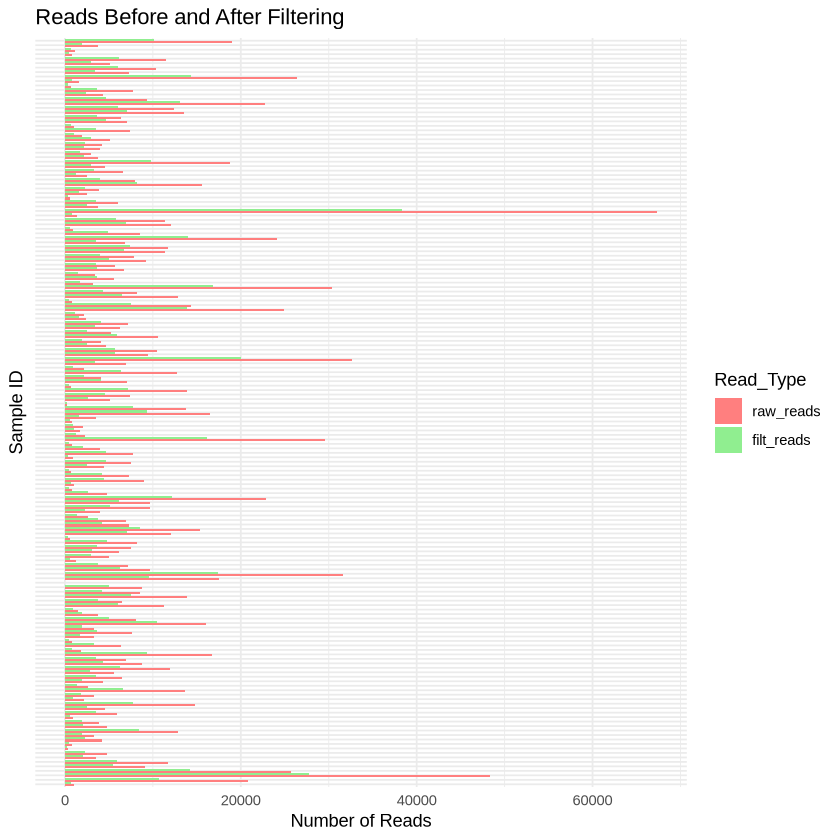

In [8]:
# Plot
ggplot(df_long, aes(x = Count, y = ID_Sample, fill = Read_Type)) +
  geom_bar(stat = "identity", position = "dodge") +  # Use "stack" for stacked bars
  theme_minimal() +
  scale_fill_manual(values = c("raw_reads" = "#FF7F7F", "filt_reads" = "#90EE90")) +
  labs(title = "Reads Before and After Filtering",
       x = "Number of Reads",
       y = "Sample ID") +
  theme(axis.text.y = element_blank(),  # Removes x-axis text (sample names)
       axis.ticks.y = element_blank())  # Removes x-axis ticks
# Save the plot as a PNG file
dev.copy(png, filename = "chopper_filt.png", width = 1200, height = 1600, res = 300)
dev.off()  # Close the PNG device